# Final project for CMPE 343-Business Intelligence and Applied Analytics 

### In this project we used the Kaggle Competition https://www.kaggle.com/c/restaurant-revenue-prediction 

#### Team members are:
-Oğulcan Gök

-Agit Çelik

-Selim Kundakçıoğlu

-Arda Alparslan

In [1]:
#Importing required libraries
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np 
import pandas as pd 

#reading the csv data
trainData = pd.read_csv('train.csv')
trainData.info()

trainData.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
Id            137 non-null int64
Open Date     137 non-null object
City          137 non-null object
City Group    137 non-null object
Type          137 non-null object
P1            137 non-null int64
P2            137 non-null float64
P3            137 non-null float64
P4            137 non-null float64
P5            137 non-null int64
P6            137 non-null int64
P7            137 non-null int64
P8            137 non-null int64
P9            137 non-null int64
P10           137 non-null int64
P11           137 non-null int64
P12           137 non-null int64
P13           137 non-null float64
P14           137 non-null int64
P15           137 non-null int64
P16           137 non-null int64
P17           137 non-null int64
P18           137 non-null int64
P19           137 non-null int64
P20           137 non-null int64
P21           137 non-null int64
P22           137 non-nul

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


## PREPROCESSiNG  & SOME  ANALYSiS

In [2]:
#Converting Open Date column to Open Days; day count of the restaurant since the beginning
#and dropping the Open Date Columns
trainData['Open Date'] = pd.to_datetime(trainData['Open Date'], format='%m/%d/%Y')   
trainData['OpenDays']=""

dateLastTrain = pd.DataFrame({'Date':np.repeat(['01/01/2015'],[len(trainData)]) })
dateLastTrain['Date'] = pd.to_datetime(dateLastTrain['Date'], format='%m/%d/%Y')  

trainData['OpenDays'] = dateLastTrain['Date'] - trainData['Open Date']
trainData['OpenDays'] = trainData['OpenDays'].astype('timedelta64[D]').astype(int)

trainData = trainData.drop('Open Date', axis=1)

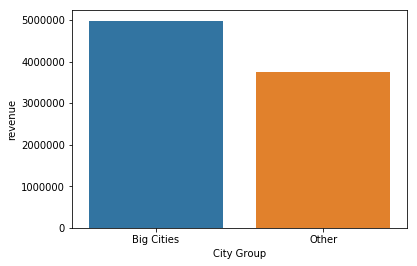

In [3]:
#Comparing the revenues of big cities and other cities
cityPerc = trainData[["City Group", "revenue"]].groupby(['City Group'],as_index=False).mean()

sns.barplot(x='City Group', y='revenue', data=cityPerc)

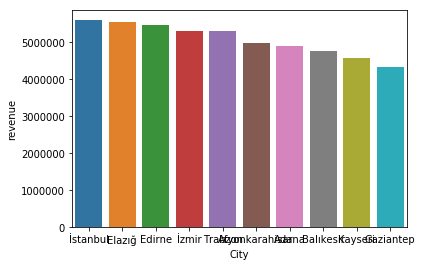

In [4]:
#Sorting the cities by revenue; getting the max earned cities
cityPerc = trainData[["City", "revenue"]].groupby(['City'],as_index=False).mean()

newDF = cityPerc.sort_values(["revenue"],ascending= False)
sns.barplot(x='City', y='revenue', data=newDF.head(10))

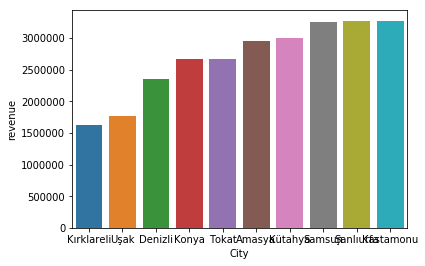

In [5]:
cityPerc = trainData[["City", "revenue"]].groupby(['City'],as_index=False).mean()
newDF = cityPerc.sort_values(["revenue"],ascending= True)
sns.barplot(x='City', y='revenue', data=newDF.head(10))

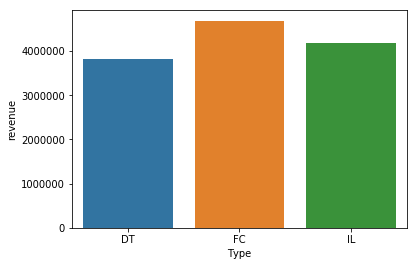

In [6]:
#Getting an insight of which restaurant type earns more
cityPerc = trainData[["Type", "revenue"]].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='revenue', data=cityPerc)

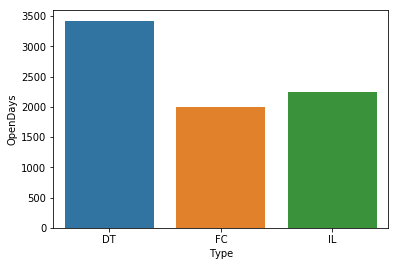

In [7]:
#Plot about working days of specific restaurant types
cityPerc = trainData[["Type", "OpenDays"]].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='OpenDays', data=cityPerc)

In [8]:
#Dropping the Id and Type columns since they are irrevelant for our predictions
trainData = trainData.drop('Id', axis=1)

trainData = trainData.drop('Type', axis=1)

In [9]:
#Creating dummy variables to represent City Groups
citygroupDummy = pd.get_dummies(trainData['City Group'])
trainData = trainData.join(citygroupDummy)

#After doing dummy variables for City Group we dropped it
trainData = trainData.drop('City Group', axis=1)

trainData = trainData.drop('City', axis=1)

tempRev = trainData['revenue']
trainData = trainData.drop('revenue', axis=1)


trainData = trainData.join(tempRev)

In [10]:
trainData.head(10)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P32,P33,P34,P35,P36,P37,OpenDays,Big Cities,Other,revenue
0,4,5.0,4.0,4.0,2,2,5,4,5,5,...,4,5,5,4,3,4,5647,1,0,5653753.0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,...,0,0,0,0,0,0,2513,1,0,6923131.0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,...,0,0,0,0,0,0,663,0,1,2055379.0
3,6,4.5,6.0,6.0,4,4,10,8,10,10,...,10,6,18,12,12,6,1064,0,1,2675511.0
4,3,4.0,3.0,4.0,2,2,5,5,5,5,...,3,2,3,4,3,3,2063,0,1,4316715.0
5,6,6.0,4.5,7.5,8,10,10,8,8,8,...,0,0,0,0,0,0,1784,1,0,5017319.0
6,2,3.0,4.0,4.0,1,5,5,5,5,5,...,2,2,3,5,4,4,1543,1,0,5166635.0
7,4,5.0,4.0,5.0,2,3,5,4,4,4,...,0,0,0,0,0,0,1290,1,0,4491607.0
8,1,1.0,4.0,4.0,1,2,1,5,5,5,...,5,3,4,5,4,5,1587,0,1,4952497.0
9,6,4.5,6.0,7.5,6,4,10,10,10,10,...,0,0,0,0,0,0,1142,0,1,5444227.0


# Train and  Test Split for RandomForestClassifier

In [11]:


from sklearn.model_selection import train_test_split

X, y = trainData.iloc[:, 1:40].values, trainData.iloc[:, 40].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                )
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95, 39), (42, 39), (95,), (42,))

In [12]:
y[:20]

array([ 5653753.,  6923131.,  2055379.,  2675511.,  4316715.,  5017319.,
        5166635.,  4491607.,  4952497.,  5444227.,  3745135.,  5161370.,
        1734634.,  4807746.,  1999097.,  3218918., 19696939.,  8213524.,
        5337526.,  2021934.])

In [13]:
y_train[:20]

array([1882131., 2364478., 1619683., 3426169., 3218918., 4888774.,
       6836483., 7217634., 4350573., 2675511., 1763231., 3248660.,
       2390534., 5166635., 4590423., 2544857., 2993069., 4067566.,
       4219263., 4780607.])

# For finding best features among others.

In [34]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = trainData.columns[1:40]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)



importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
#print X_train.shape[1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
    
    


 1) OpenDays                       0.087800
 2) P19                            0.049030
 3) P11                            0.048616
 4) P28                            0.048073
 5) P6                             0.047423
 6) P2                             0.046847
 7) P20                            0.044270
 8) P22                            0.041101
 9) P5                             0.038940
10) P23                            0.035039
11) P4                             0.033633
12) P8                             0.032433
13) P3                             0.031882
14) P29                            0.030229
15) P12                            0.027642
16) P21                            0.027468
17) Big Cities                     0.021086
18) Other                          0.019282
19) P13                            0.018407
20) P9                             0.018130
21) P7                             0.017888
22) P10                            0.017070
23) P32                         

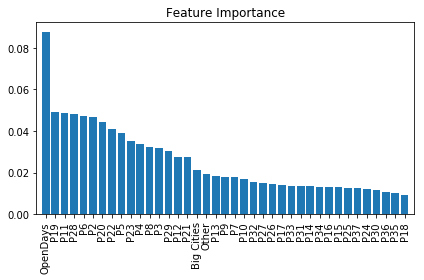

In [35]:
#hepsi
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()


In [15]:
trainData[feat_labels[indices[0:39]]].head()

,OpenDays,P19,P11,P28,P6,P2,P20,P22,P5,P23,...,P34,P16,P15,P25,P37,P24,P30,P36,P35,P18
0,5647,5,3,2.0,2,5.0,4,3,2,3,...,5,2,2,1,4,1,5,3,4,4
1,2513,3,1,3.0,2,5.0,2,3,1,2,...,0,0,0,0,0,0,0,0,0,0
2,663,1,2,1.0,3,4.0,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
3,1064,20,8,2.5,4,4.5,12,1,4,10,...,18,9,4,2,6,2,25,12,12,12
4,2063,2,2,1.0,2,4.0,2,2,2,1,...,3,2,1,3,3,2,5,3,4,4


# Test and Train model created over best 19 features.

In [16]:
#Model will predict output by using best 19 features.


bestDataFeaturesTrain = trainData[feat_labels[indices[0:19]]]

y = trainData.iloc[:, 40].values

from sklearn.model_selection import train_test_split

X, y = trainData.iloc[:, 1:40].values, trainData.iloc[:, 40].values

X_trainForModel, X_testForModel, y_trainForModel, y_testForModel =\
    train_test_split(bestDataFeaturesTrain, y, 
                     test_size=0.3, 
                     random_state=0, 
                )



    
X_trainForModel.shape, X_testForModel.shape, y_trainForModel.shape, y_testForModel.shape

((95, 19), (42, 19), (95,), (42,))

# Standardize features by removing the mean and scaling to unit variance

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_std  = True ,with_mean = True, copy = True)
X_train_std = sc.fit_transform(X_trainForModel)
X_test_std = sc.transform(X_testForModel)

In [18]:
X_train_std[:1]

array([[-0.16928962, -0.11198837, -0.11231348, -0.5053225 , -1.10011554,
        -1.57830974, -0.34948465, -0.9324214 , -0.84773376, -0.26093616,
        -1.37291772, -0.58444341, -0.21892229, -0.03964349, -0.10006797,
        -0.6692546 , -1.17260394,  1.17260394, -0.06520776]])

# 

In [19]:
from sklearn.decomposition import PCA,KernelPCA

pca = PCA(n_components=2,svd_solver='full')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca.explained_variance_ratio_

kpca = KernelPCA(kernel="rbf", gamma=1)
X_kpca = kpca.fit_transform(X_train_pca)
X_kpca_test = kpca.transform(X_test_pca)

X_train_pca[:1]


array([[-2.16781863,  1.86008789]])

Text(0.5,0,'After RBF')

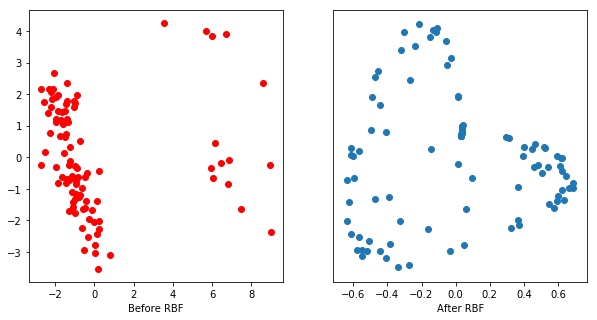

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1],color='red',marker='o')
ax[1].scatter(X_kpca[:, 0], X_kpca[:, 1])
ax[0].set_xlabel('Before RBF')
ax[1].set_yticks([])
ax[1].set_xlabel('After RBF')


In [21]:
X_test_pca[:1]

array([[-0.07139362, -1.50050288]])

In [22]:
X_trainForModel.head()


,OpenDays,P19,P11,P28,P6,P2,P20,P22,P5,P23,P4,P8,P3,P29,P12,P21,Big Cities,Other,P13
66,1818,4,3,2.0,1,2.0,3,1,1,2,3.0,4,4.0,3.0,5,1,0,1,5.0
89,2061,2,1,1.0,2,1.0,1,1,1,1,3.0,5,4.0,3.0,5,1,1,0,5.0
63,514,2,2,1.0,1,2.0,1,1,3,1,4.0,5,4.0,3.0,5,1,0,1,5.0
90,511,15,4,5.0,8,7.5,9,3,2,5,6.0,10,6.0,7.5,8,3,1,0,6.0
15,1059,10,4,7.5,10,7.5,9,2,2,5,6.0,10,6.0,7.5,10,3,1,0,7.5


In [23]:
X_train_std[:1]

array([[-0.16928962, -0.11198837, -0.11231348, -0.5053225 , -1.10011554,
        -1.57830974, -0.34948465, -0.9324214 , -0.84773376, -0.26093616,
        -1.37291772, -0.58444341, -0.21892229, -0.03964349, -0.10006797,
        -0.6692546 , -1.17260394,  1.17260394, -0.06520776]])

In [24]:
X_testForModel.head()

,OpenDays,P19,P11,P28,P6,P2,P20,P22,P5,P23,P4,P8,P3,P29,P12,P21,Big Cities,Other,P13
26,1773,5,5,3.0,3,5.0,5,3,2,2,5.0,3,4.0,3.0,5,2,1,0,4.0
8,1587,1,1,2.0,2,1.0,1,1,1,1,4.0,5,4.0,3.0,5,1,0,1,5.0
86,1255,3,3,2.0,2,3.0,5,3,2,2,4.0,4,4.0,3.0,5,1,0,1,5.0
78,824,25,4,7.5,6,7.5,12,2,8,10,7.5,10,6.0,2.5,6,6,1,0,6.0
43,1925,1,2,1.0,2,4.0,1,2,1,1,4.0,5,5.0,3.0,5,1,1,0,5.0


In [25]:
X_testForModel.head()


,OpenDays,P19,P11,P28,P6,P2,P20,P22,P5,P23,P4,P8,P3,P29,P12,P21,Big Cities,Other,P13
26,1773,5,5,3.0,3,5.0,5,3,2,2,5.0,3,4.0,3.0,5,2,1,0,4.0
8,1587,1,1,2.0,2,1.0,1,1,1,1,4.0,5,4.0,3.0,5,1,0,1,5.0
86,1255,3,3,2.0,2,3.0,5,3,2,2,4.0,4,4.0,3.0,5,1,0,1,5.0
78,824,25,4,7.5,6,7.5,12,2,8,10,7.5,10,6.0,2.5,6,6,1,0,6.0
43,1925,1,2,1.0,2,4.0,1,2,1,1,4.0,5,5.0,3.0,5,1,1,0,5.0


In [26]:
y_testForModel

array([ 2267425.,  4952497.,  3351383.,  3871344.,  2732645.,  7495092.,
        3956086.,  2156098.,  3752885.,  8904084.,  3600467.,  2097022.,
        4651866.,  5435276.,  5286212.,  4882985.,  4155435.,  4286645.,
        4467728.,  4250553.,  3164972.,  5337526.,  6782425.,  2371202.,
        3753720.,  7201784.,  4491607., 19696939.,  2383840.,  3745135.,
        2055379.,  3273041.,  4758476.,  8894598.,  3008199.,  6694797.,
        3347767.,  4136425.,  4264176.,  3570392.,  3199619.,  4807746.])

# RandomForestRegressor is used to predict "revenues"

In [27]:
yTrainTemp = trainData['revenue']


import numpy
from sklearn import linear_model
cls = RandomForestRegressor(n_estimators=250, criterion='mse', max_depth=30)#cls = RandomForestRegressor(n_estimators=150)

cls.fit(X_kpca, y_trainForModel)

scoreOfModel = cls.score(X_kpca, y_trainForModel)


print("Score is calculated as: ",scoreOfModel)

Score is calculated as:  0.8377399268816645


In [28]:
pred = cls.predict(X_kpca_test)
pred

array([4942920.74 , 3648170.356, 4532101.408, 5121261.312, 4933991.624,
       5852044.268, 5019821.464, 6814897.872, 5160222.32 , 4763768.028,
       5600636.656, 3506309.544, 4510079.732, 6348119.264, 3725792.616,
       5243568.16 , 5628707.516, 5175366.492, 5364117.28 , 3998059.252,
       4864635.36 , 5589097.276, 5030542.836, 3641407.164, 3692794.264,
       5397692.628, 5358405.664, 5541187.368, 5577743.32 , 4930828.98 ,
       3882246.8  , 5475221.976, 5584836.528, 4707584.012, 5449242.956,
       5152761.492, 7170348.376, 4843514.644, 5117476.032, 5260448.076,
       4066215.104, 3814551.188])

In [36]:
from sklearn.ensemble import RandomForestClassifier
rclf = RandomForestClassifier()
rclf.fit(X_kpca, y_trainForModel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
y_pred = rclf.predict(X_kpca_test)
print(len(X_kpca_test))
print(accuracy_score(y_test,y_pred))


42
0.0


In [46]:
y_test[:10]

array([2267425., 4952497., 3351383., 3871344., 2732645., 7495092.,
       3956086., 2156098., 3752885., 8904084.])

## Effect of estimators on score graphically shown below 

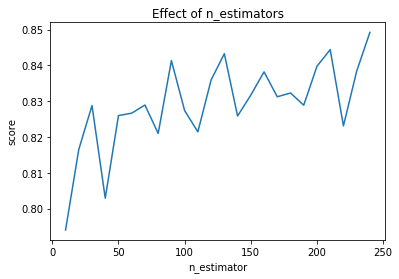

In [29]:
estimators = np.arange(10, 250, 10) # 10 to 250 increased with 10
scores = []
for n in estimators:
    cls.set_params(n_estimators=n)
    cls.fit(X_train_pca, y_trainForModel)
    scores.append(cls.score(X_train_pca, y_trainForModel))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

# Plot Revenues(orenge line) and Predicted Revenues(blue line)

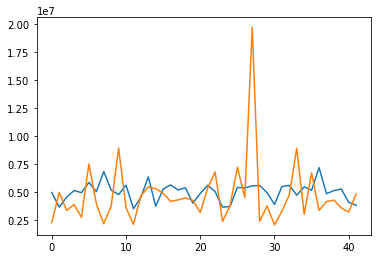

In [30]:

r = []
for pair in  zip(pred, y_testForModel):
    r.append(pair)

plt.plot(r)


In [31]:
pred[:20]

array([4942920.74 , 3648170.356, 4532101.408, 5121261.312, 4933991.624,
       5852044.268, 5019821.464, 6814897.872, 5160222.32 , 4763768.028,
       5600636.656, 3506309.544, 4510079.732, 6348119.264, 3725792.616,
       5243568.16 , 5628707.516, 5175366.492, 5364117.28 , 3998059.252])

In [32]:
yTrainTemp.head(20)

0      5653753.0
1      6923131.0
2      2055379.0
3      2675511.0
4      4316715.0
5      5017319.0
6      5166635.0
7      4491607.0
8      4952497.0
9      5444227.0
10     3745135.0
11     5161370.0
12     1734634.0
13     4807746.0
14     1999097.0
15     3218918.0
16    19696939.0
17     8213524.0
18     5337526.0
19     2021934.0
Name: revenue, dtype: float64

In [33]:
for z in zip(y_testForModel, pred):
    print(z, (z[0]-z[1]) /z[0] )


(2267425.0, 4942920.74) -1.1799709979381898
(4952497.0, 3648170.356) 0.2633674778601582
(3351383.0, 4532101.408) -0.3523078108351089
(3871344.0, 5121261.312) -0.32286392322666235
(2732645.0, 4933991.624) -0.8055735831035498
(7495092.0, 5852044.268) 0.21921648620190384
(3956086.0, 5019821.464) -0.26888582907449426
(2156098.0, 6814897.872) -2.160755156769312
(3752885.0, 5160222.32) -0.37500145088378684
(8904084.0, 4763768.028) 0.4649906685516444
(3600467.0, 5600636.656) -0.5555306175560005
(2097022.0, 3506309.544) -0.6720423266899442
(4651866.0, 4510079.732) 0.030479439433552073
(5435276.0, 6348119.264) -0.1679479135926125
(5286212.0, 3725792.616) 0.2951866826377754
(4882985.0, 5243568.16) -0.07384482237811506
(4155435.0, 5628707.516) -0.35454110484221263
(4286645.0, 5175366.492) -0.20732332441804713
(4467728.0, 5364117.28) -0.200636493537655
(4250553.0, 3998059.252) 0.059402564325159606
(3164972.0, 4864635.36) -0.5370231900945728
(5337526.0, 5589097.276) -0.047132562164568306
(6782425.0